Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np
import optuna
from optuna.trial import TrialState
import pickle
import uncertainty_toolbox as uct
import pandas as pd

# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':      # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

from utils.data_prep import load_tranform_and_split_data, set_seed
from utils.metrices import evaluate_intervals
from utils.NN_model import Custom_NN_Model, train_model, heteroscedastic_loss

Load and transform the data

In [2]:
#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
torch.Size([31206, 1]) torch.Size([10402, 1]) torch.Size([10403, 1])


Hyperparameter Search with Optuna

In [28]:
def objective(trial):
    
    # hyperparameter for sampling with Optuna
    #n_layer = trial.suggest_int("n_layer", 2, 3)  # number of hidden layers
    #n_neurons = trial.suggest_int("n_neurons", 256, 640, step=32)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.10, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128])
    weight_decay = trial.suggest_float("wd", 1e-8, 1e-5, log=True)  # weight decay for regularization

    #decay = 0.7

    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    # this creates a list of integers representing the number of neurons in each hidden layer
    #hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    #print(f"Hidden dimensions: {hidden_dims}")
    hidden_dims = [320,224,156]
    #epochs = 1000  # maximum number of epochs for training
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 50  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss


In [29]:
print(f"Using device: {device}")

# number of epochs for training
epochs = 1000

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-09-28 17:15:17,330] A new study created in memory with name: no-name-00d88e3f-2b9c-4708-9fb7-297bf927c63a


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping at epoch 336, Best Val Loss: 1.6302
[I 2025-09-28 17:25:40,166] Trial 0 finished with value: 1.630172848701477 and parameters: {'do_rate': 0.3264979643019531, 'lr': 0.0032568135224766382, 'batch_size': 64, 'wd': 7.384302666564018e-08}. Best is trial 0 with value: 1.630172848701477.
Early stopping at epoch 571, Best Val Loss: 1.7677
[I 2025-09-28 17:43:19,702] Trial 1 finished with value: 1.7676600217819214 and parameters: {'do_rate': 0.14423143937628688, 'lr': 7.231330405934065e-05, 'batch_size': 64, 'wd': 3.567091938068423e-08}. Best is trial 0 with value: 1.630172848701477.
Early stopping at epoch 854, Best Val Loss: 2.1102
[I 2025-09-28 17:58:04,006] Trial 2 finished with value: 2.1102302074432373 and parameters: {'do_rate': 0.35292336126089074, 'lr': 7.662877988148026e-05, 'batch_size': 128, 'wd': 7.066279085250503e-06}. Best is trial 0 with value: 1.630172848701477.
Early stopping at epoch 869, Best Val Loss: 1.5254
[I 2025-09-28 18:24:51,000] Trial 3 finished with 

Train the Model

In [ ]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#set_seed(SEED)  # Set the seed for reproducibility
# Move training and val data  to device

# Create heteroscedastic model instance with best parameters and move to device
model_heteroscedastic = Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[320,224,156], 
                                                 output_dim=1, do_rate=0.209, 
                                                 loss_type = 'heteroscedastic').to(device)  # Create model instance and move to device
#print(f"Model: {model_heteroscedastic}")
# Train the model with the best parameters
optimizer_heteroscedastic = torch.optim.AdamW(params = model_heteroscedastic.parameters(), lr = 0.0015, weight_decay = 3.820457176351347e-06)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_heteroscedastic = train_model(model_heteroscedastic, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, 
                                                X_val_tensor=X_val_tensor, y_val_tensor=y_val_tensor, batch_size=64, 
                                                n_epochs=1000, optimizer= optimizer_heteroscedastic, patience=50, 
                                                loss_type='heteroscedastic', device = device)

Using device: cuda
Using device: cuda
Epoch 1/1000, Train Loss: 52.0608, Val Loss: 5.4195, Best Val Loss: 5.4195
Epoch 2/1000, Train Loss: 4.7551, Val Loss: 3.5499, Best Val Loss: 3.5499
Epoch 3/1000, Train Loss: 3.7100, Val Loss: 3.3582, Best Val Loss: 3.3582
Epoch 4/1000, Train Loss: 3.5185, Val Loss: 3.2520, Best Val Loss: 3.2520
Epoch 5/1000, Train Loss: 3.3755, Val Loss: 3.2107, Best Val Loss: 3.2107
Epoch 6/1000, Train Loss: 3.3257, Val Loss: 3.1597, Best Val Loss: 3.1597
Epoch 7/1000, Train Loss: 3.2973, Val Loss: 3.0717, Best Val Loss: 3.0717
Epoch 8/1000, Train Loss: 3.2541, Val Loss: 3.0265, Best Val Loss: 3.0265
Epoch 9/1000, Train Loss: 3.2393, Val Loss: 2.8428, Best Val Loss: 2.8428
Epoch 10/1000, Train Loss: 3.1802, Val Loss: 2.7025, Best Val Loss: 2.7025
Epoch 11/1000, Train Loss: 3.0045, Val Loss: 2.6420, Best Val Loss: 2.6420
Epoch 12/1000, Train Loss: 2.9914, Val Loss: 2.5390, Best Val Loss: 2.5390
Epoch 13/1000, Train Loss: 2.9966, Val Loss: 2.4518, Best Val Loss: 2.

Make Predictions

In [6]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_heteroscedastic.train()

# Number of stochastic forward passes for MC Dropout
n_samples = 250
set_seed(42)  # Set the seed for reproducibility
# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_heteroscedastic_mean = []
y_train_pred_heteroscedastic_var= []

for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_train_tensor)
    mean_np, log_var_np = mean.detach().cpu().numpy(), log_var.detach().cpu().numpy()
    y_train_pred_heteroscedastic_mean.append(mean_np)
    y_train_pred_heteroscedastic_var.append(np.exp(log_var_np))

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_heteroscedastic_mean = []
y_test_pred_heteroscedastic_var = []
for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_test_tensor.to(device))
    mean_np, log_var_np = mean.detach().cpu().numpy(), log_var.detach().cpu().numpy()
    y_test_pred_heteroscedastic_mean.append(mean_np)
    y_test_pred_heteroscedastic_var.append(np.exp(log_var_np))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

Evaluate Predictions

Epistemic Variance: 1.769236
Aleatoric Variance: 7.676959
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.027
  RMSE          2.848
  MDAE          1.517
  MARPD         1.769
  R2            0.858
  Correlation   0.927
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.059
  Mean-absolute Calibration Error       0.054
  Miscalibration Area                   0.054
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.067
     Group Size: 0.56 -- Calibration Error: 0.057
     Group Size: 1.00 -- Calibration Error: 0.054
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.059
================

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

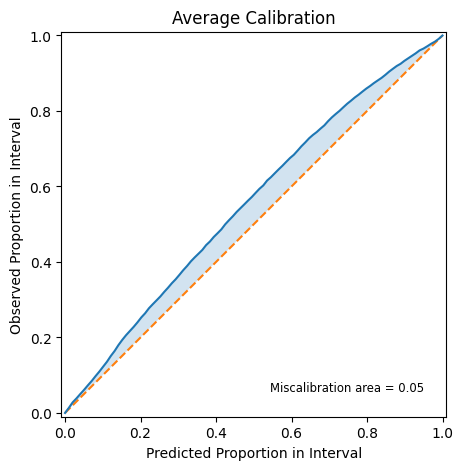

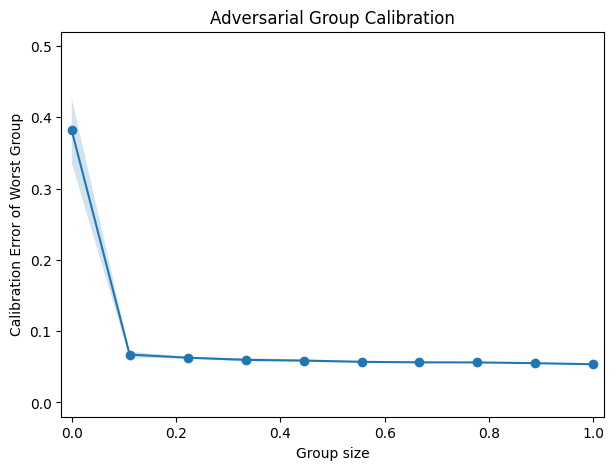

In [45]:
# Calculate the mean and standard deviation of the predictions on the test data
MC_mean = np.mean(y_test_pred_heteroscedastic_mean, axis = 0).reshape(-1)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(y_test_pred_heteroscedastic_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(y_test_pred_heteroscedastic_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
MC_std = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic).reshape(-1)

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics(MC_mean, MC_std, y_test)
print(pnn_metrics)
print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(MC_mean, MC_std, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = evaluate_intervals(MC_mean, MC_std, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(MC_mean, MC_std, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(MC_mean, MC_std, y_test)

Make 10 Runs with different Random Seed to evaluate MC Dropout

In [ ]:
results_list = []
predictions_list = []
list_of_seeds = [42, 123, 777, 2024, 5250, 8888, 9876, 10001, 31415, 54321]
MCD_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\MC Dropout"
MCD_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\MC Dropout"

for run, seed in enumerate(list_of_seeds):

    print(f"Run {run+1} with seed {seed}")
    set_seed(seed)

    #create a model instance and optimizer
    model = Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[320,224,156], 
                                                 output_dim=1, do_rate=0.209, 
                                                 loss_type = 'heteroscedastic')
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = 0.0015, weight_decay = 3.820457176351347e-06)  # Use AdamW optimizer with specified learning rate and weight decay
    #train model
    tr_model = train_model(model, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, 
                                                    X_val_tensor=X_val_tensor, y_val_tensor=y_val_tensor, batch_size=64, 
                                                    n_epochs=1000, optimizer= optimizer, patience=50, 
                                                    loss_type='heteroscedastic')
    
    # inference with multiple forward passes
    # keep the model in training mode to keep dropout active
    tr_model.train()

    # Number of stochastic forward passes for MC Dropout
    n_samples = 250

    # Make multiple stochastic predictions (MC Dropout) on the test data
    outputs_mean = []
    outputs_log_var = []
    for i in range(n_samples):
        mean, log_var = tr_model(X_test_tensor.to(device))
        mean_np, log_var_np = mean.detach().cpu().numpy(), log_var.detach().cpu().numpy()
        outputs_mean.append(mean_np)
        outputs_log_var.append(np.exp(log_var_np))

    outputs_mean = np.array(outputs_mean)
    outputs_log_var = np.array(outputs_log_var)

    # Calculate the mean and standard deviation of the predictions on the test data
    MC_mean = np.mean(outputs_mean, axis = 0).reshape(-1) # reshape to 1D array

    # Calculate epistemic
    MC_epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
    print(f"Epistemic Variance: {MC_epistemic_var_heteroscedastic.mean():.6f}")

    # Calculate aleatoric variance (heteroscedastic)
    MC_aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
    print(f"Aleatoric Variance: {MC_aleatoric_var_heteroscedastic.mean():.6f}")

    # Calculate total standard deviation
    MC_std = np.sqrt(MC_epistemic_var_heteroscedastic + MC_aleatoric_var_heteroscedastic).reshape(-1) # reshape to 1D array

    # Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
    pnn_metrics = uct.metrics.get_all_metrics(MC_mean, MC_std, y_test)
    print(pnn_metrics)

    # use own function to calculate coverage and MPIW
    ev_intervals = evaluate_intervals(MC_mean, MC_std, y_test, coverage=0.95)
    print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

    predictions_per_run = {
        'mean_prediction': MC_mean,
        'std_prediction': MC_std,
    }

    results_per_run = {
    'RMSE': pnn_metrics['accuracy']['rmse'],
    'MAE': pnn_metrics['accuracy']['mae'],
    'R2': pnn_metrics['accuracy']['r2'], 
    'Correlation' : pnn_metrics['accuracy']['corr'],
    'NLL': pnn_metrics['scoring_rule']['nll'],
    'CRPS': pnn_metrics['scoring_rule']['crps'],
    'coverage': ev_intervals["coverage"],
    'MPIW': ev_intervals["MPIW"],
    }

    predictions_list.append(predictions_per_run)
    results_list.append(results_per_run)
#save the predictions 
with open(os.path.join(MCD_prediction_path, "MC_predictions_list.pkl"), "wb") as f:
    pickle.dump(predictions_list, f)

#save the results in an excel file
results_df = pd.DataFrame(results_list)
results_df.to_excel(os.path.join(MCD_result_path, "MC_results.xlsx"), index=False)

Run 1 with seed 42
Using device: cuda
Epoch 1/1000, Train Loss: 52.0861, Val Loss: 5.4039, Best Val Loss: 5.4039
Epoch 2/1000, Train Loss: 4.7401, Val Loss: 3.5660, Best Val Loss: 3.5660
Epoch 3/1000, Train Loss: 3.7227, Val Loss: 3.3727, Best Val Loss: 3.3727
Epoch 4/1000, Train Loss: 3.5767, Val Loss: 3.2350, Best Val Loss: 3.2350
Epoch 5/1000, Train Loss: 3.4011, Val Loss: 3.1739, Best Val Loss: 3.1739
Epoch 6/1000, Train Loss: 3.3369, Val Loss: 3.1453, Best Val Loss: 3.1453
Epoch 7/1000, Train Loss: 3.2998, Val Loss: 3.0292, Best Val Loss: 3.0292
Epoch 8/1000, Train Loss: 3.2540, Val Loss: 2.9821, Best Val Loss: 2.9821
Epoch 9/1000, Train Loss: 3.2414, Val Loss: 2.8370, Best Val Loss: 2.8370
Epoch 10/1000, Train Loss: 3.1915, Val Loss: 2.6886, Best Val Loss: 2.6886
Epoch 11/1000, Train Loss: 3.0300, Val Loss: 2.6220, Best Val Loss: 2.6220
Epoch 12/1000, Train Loss: 2.9897, Val Loss: 2.5486, Best Val Loss: 2.5486
Epoch 13/1000, Train Loss: 2.9907, Val Loss: 2.5020, Best Val Loss: 2.

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.113
  RMSE          2.940
  MDAE          1.545
  MARPD         1.841
  R2            0.849
  Correlation   0.925
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.139
  Mean-absolute Calibration Error       0.124
  Miscalibration Area                   0.125
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.138
     Group Size: 0.56 -- Calibration Error: 0.127
     Group Size: 1.00 -- Calibration Error: 0.124
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.150
     Group Size: 0.56 -- Calibration Error: 0.143
     Group Size: 1.00 -- Calibration Error: 0.139
================

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.075
  RMSE          2.899
  MDAE          1.530
  MARPD         1.809
  R2            0.853
  Correlation   0.925
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.145
  Mean-absolute Calibration Error       0.130
  Miscalibration Area                   0.131
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.141
     Group Size: 0.56 -- Calibration Error: 0.134
     Group Size: 1.00 -- Calibration Error: 0.130
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.157
     Group Size: 0.56 -- Calibration Error: 0.150
     Group Size: 1.00 -- Calibration Error: 0.145
================

100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.155
  RMSE          2.978
  MDAE          1.637
  MARPD         1.876
  R2            0.845
  Correlation   0.924
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.143
  Mean-absolute Calibration Error       0.130
  Miscalibration Area                   0.131
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.142
     Group Size: 0.56 -- Calibration Error: 0.133
     Group Size: 1.00 -- Calibration Error: 0.130
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.155
     Group Size: 0.56 -- Calibration Error: 0.147
     Group Size: 1.00 -- Calibration Error: 0.143
================

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.052
  RMSE          2.878
  MDAE          1.531
  MARPD         1.792
  R2            0.855
  Correlation   0.925
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.144
  Mean-absolute Calibration Error       0.130
  Miscalibration Area                   0.131
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.140
     Group Size: 0.56 -- Calibration Error: 0.134
     Group Size: 1.00 -- Calibration Error: 0.130
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.157
     Group Size: 0.56 -- Calibration Error: 0.148
     Group Size: 1.00 -- Calibration Error: 0.144
================

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.181
  RMSE          2.998
  MDAE          1.668
  MARPD         1.901
  R2            0.843
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.238
  Mean-absolute Calibration Error       0.214
  Miscalibration Area                   0.216
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.222
     Group Size: 0.56 -- Calibration Error: 0.216
     Group Size: 1.00 -- Calibration Error: 0.214
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.246
     Group Size: 0.56 -- Calibration Error: 0.241
     Group Size: 1.00 -- Calibration Error: 0.238
================

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.094
  RMSE          2.897
  MDAE          1.574
  MARPD         1.827
  R2            0.853
  Correlation   0.925
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.138
  Mean-absolute Calibration Error       0.123
  Miscalibration Area                   0.125
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.134
     Group Size: 0.56 -- Calibration Error: 0.126
     Group Size: 1.00 -- Calibration Error: 0.123
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.147
     Group Size: 0.56 -- Calibration Error: 0.142
     Group Size: 1.00 -- Calibration Error: 0.138
================

100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.145
  RMSE          2.977
  MDAE          1.619
  MARPD         1.871
  R2            0.845
  Correlation   0.920
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.197
  Mean-absolute Calibration Error       0.177
  Miscalibration Area                   0.178
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.187
     Group Size: 0.56 -- Calibration Error: 0.180
     Group Size: 1.00 -- Calibration Error: 0.177
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.208
     Group Size: 0.56 -- Calibration Error: 0.200
     Group Size: 1.00 -- Calibration Error: 0.197
================

100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.077
  RMSE          2.892
  MDAE          1.551
  MARPD         1.814
  R2            0.854
  Correlation   0.924
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.195
  Mean-absolute Calibration Error       0.176
  Miscalibration Area                   0.178
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.189
     Group Size: 0.56 -- Calibration Error: 0.179
     Group Size: 1.00 -- Calibration Error: 0.176
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.206
     Group Size: 0.56 -- Calibration Error: 0.198
     Group Size: 1.00 -- Calibration Error: 0.195
================

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.088
  RMSE          2.940
  MDAE          1.556
  MARPD         1.819
  R2            0.849
  Correlation   0.923
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.114
  Mean-absolute Calibration Error       0.102
  Miscalibration Area                   0.103
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.113
     Group Size: 0.56 -- Calibration Error: 0.106
     Group Size: 1.00 -- Calibration Error: 0.102
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.126
     Group Size: 0.56 -- Calibration Error: 0.118
     Group Size: 1.00 -- Calibration Error: 0.114
================

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.063
  RMSE          2.899
  MDAE          1.558
  MARPD         1.801
  R2            0.853
  Correlation   0.924
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.131
  Mean-absolute Calibration Error       0.117
  Miscalibration Area                   0.118
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.127
     Group Size: 0.56 -- Calibration Error: 0.120
     Group Size: 1.00 -- Calibration Error: 0.117
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.144
     Group Size: 0.56 -- Calibration Error: 0.135
     Group Size: 1.00 -- Calibration Error: 0.131
================

In [4]:
MCD_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\MC Dropout"
MCD_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\MC Dropout"

with open(os.path.join(MCD_prediction_path, "MC_predictions_list.pkl"), "rb") as f:
    predictions_list = pickle.load(f)

mean_list = []
std_list = []

for id, run in enumerate(predictions_list):
    # extract mean and std predictions
    mean = run['mean_prediction']
    std = run['std_prediction']
    
    # append to lists
    mean_list.append(mean)
    std_list.append(std)
    
    # calibration Curve with UCT
    uct.viz.plot_calibration(mean, std, y_test)
    plt.savefig(os.path.join(MCD_result_path, f"calibration_run_{id+1}.svg"), format ='svg')
    plt.close()

    # adversarial group calibration
    uct.viz.plot_adversarial_group_calibration(mean, std, y_test)
    plt.savefig(os.path.join(MCD_result_path, f"adversarial_group_calibration_run_{id+1}.svg"), format ='svg')
    plt.close()

# predictions_list enthält pro Run ein Array mit 10403 Werten
mean_matrix = np.array(mean_list)  # Shape: (n_runs, 10403)
std_matrix = np.array(std_list)    # Shape: (n_runs, 10403)

# Mittelwert und Std für jeden Datenpunkt über alle Runs
mean_per_datapoint = np.mean(mean_matrix, axis=0)  # Shape: (10403,)
std_per_datapoint = np.mean(std_matrix, axis=0)    # Shape: (10403,)

# calibration Curve with UCT
uct.viz.plot_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(MCD_result_path, "calibration_run_mean.svg"), format ='svg')
plt.close()

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(MCD_result_path, "adversarial_group_calibration_run_mean.svg"), format ='svg')
plt.close()

Plotting the data

Shape of y_train_pred_heteroscedastic_mean: (250, 31206, 1)
(31206, 1)
[[113.94255 ]
 [108.13482 ]
 [122.742256]
 [123.83936 ]
 [112.06473 ]]
[114.7258 106.48   121.0372 129.2826 113.5077]
R² on Train Data: 0.877
Epistemic Variance: 3.321398
Aleatoric Variance: 13.645774
Total Standard Deviation: 3.960232
 y_test std: 7.556901454925537
R² on Test Data: 0.852
Shape of mc_lower_bound: (10403,), mc_upper_bound: (10403,)
Number of true values within the confidence interval: 10319 out of 10403
Coverage: 99.19%


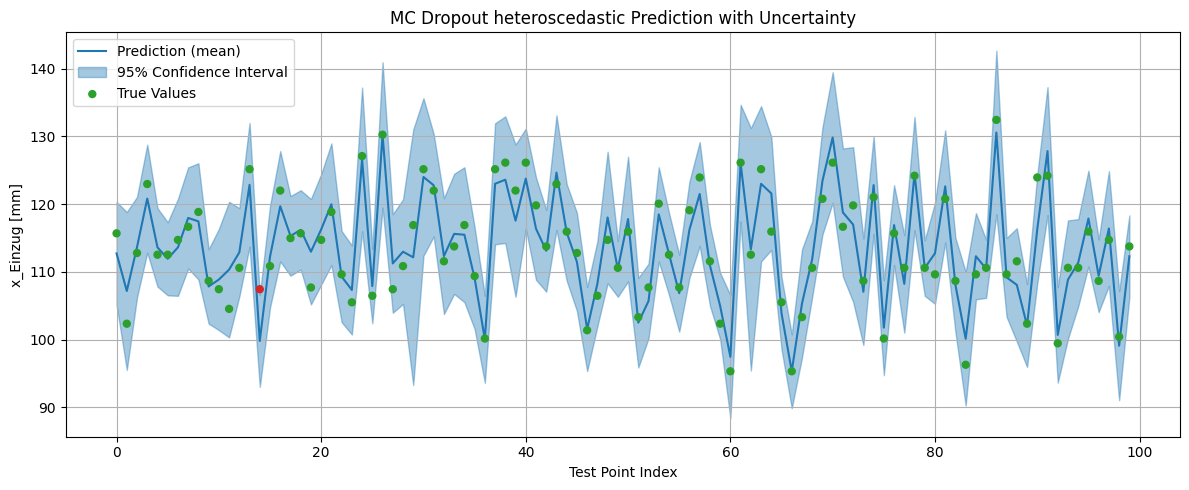

In [34]:
#! handling the train data
# Calculate the mean of the predictions on the train data
print(f"Shape of y_train_pred_heteroscedastic_mean: {np.array(y_train_pred_heteroscedastic_mean).shape}")
mean_train_pred_heteroscedastic = np.mean(y_train_pred_heteroscedastic_mean, axis=0)  # shape: (31206, 1)
print(mean_train_pred_heteroscedastic.shape)
print(mean_train_pred_heteroscedastic[:5])  # Print first 5 predictions for verification
print(y_train[:5])
# Calculate R² score on the train data
r2_train = r2_score(y_train, mean_train_pred_heteroscedastic)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(y_test_pred_heteroscedastic_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(y_test_pred_heteroscedastic_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(y_test_pred_heteroscedastic_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f}")

print(f' y_test std: {y_test_tensor.std().item()}')

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), mean_test_pred_heteroscedastic)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
mc_std = total_std_heteroscedastic    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = (mc_mean - 2 * mc_std).reshape(-1)  # Ensure it is a 1D array
mc_upper_bound = (mc_mean+ 2 * mc_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of mc_lower_bound: {mc_lower_bound.shape}, mc_upper_bound: {mc_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout heteroscedastic Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()